**1. Khai báo thư viện**

In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

**2. Hàm load data và đọc data**

In [6]:
def load_labels(label_path):
    with open(label_path, 'r') as file:
        line = file.readline().strip().split()
        return [float(coord) for coord in line[1:]]

In [8]:
def load_data(image_dir, label_dir, img_size=(224, 224)):
    images = []
    labels = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))

        if os.path.exists(label_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)

            label = load_labels(label_path)
            labels.append(label)

    return np.array(images), np.array(labels)

In [9]:
image_dir = 'Car_dataset/images'
label_dir = 'Car_dataset/labels1'
X, y = load_data(image_dir, label_dir)

**3. Xây dựng mô hình CNN**

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(224, 224, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape)) 
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
    return model


In [32]:
model = build_model()

**4. Chia tập dữ liệu 80/20 và huấn luyện mô hình**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.7650 - loss: 0.0349 - val_accuracy: 0.8500 - val_loss: 0.0080
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.9487 - loss: 0.0038 - val_accuracy: 0.8500 - val_loss: 0.0040
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.9353 - loss: 0.0021 - val_accuracy: 0.8500 - val_loss: 0.0035
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.9427 - loss: 0.0014 - val_accuracy: 0.8500 - val_loss: 0.0024
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9844 - loss: 7.5681e-04 - val_accuracy: 0.8750 - val_loss: 0.0023
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9793 - loss: 3.3459e-04 - val_accuracy: 0.8750 - val_loss: 0.0022
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9801 - loss: 2.2908e-04 - val_accuracy: 0.8750 - val_loss: 0.0020
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9980 - loss: 1.6850e-04 - 

In [18]:
model.save('license_plate_detection_model.h5')

**5. Đồ thị hiển thị kết quả huấn luyện**

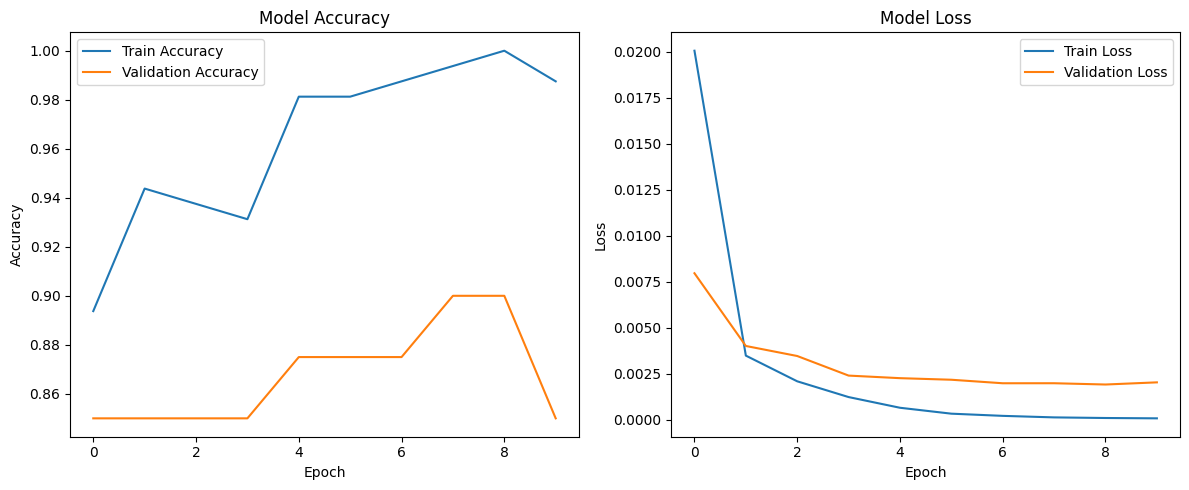

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


**6. Sử dụng mô hình phát hiện biển số xe**

In [20]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model('license_plate_detection_model.h5', custom_objects={'mse': MeanSquaredError()})

In [21]:
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, img_size)
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)
    return img_resized

In [26]:
def detect_license_plate(image_path):
    img = preprocess_image(image_path)  
    prediction = model.predict(img)[0]  

    x_center, y_center, width, height = prediction

    img_original = cv2.imread(image_path)  
    img_height, img_width, _ = img_original.shape  

    x1 = int((x_center - width / 2) * img_width)
    y1 = int((y_center - height / 2) * img_height)
    x2 = int((x_center + width / 2) * img_width)
    y2 = int((y_center + height / 2) * img_height)

    cv2.rectangle(img_original, (x1, y1), (x2, y2), (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')  # Tắt trục
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


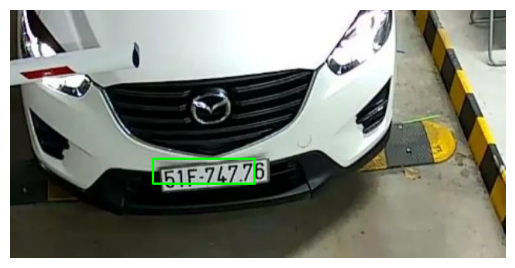

In [30]:
image_path = 'Car_dataset/images/img32.jpg'
detect_license_plate(image_path)